Dynamic:
$$x_{k}=F_k x_{k-1}+G_k u_k + w_k\\ z_k=H_k x_k + v_k$$

Kalman steps:
$$P_{k|k-1}=F_k P_{k-1|k-1} F_k^T + Q_k$$

$$x_{k|k}=x_{k|k-1} + K_k (z_k - H_k x_{k|k-1})$$

Min:
$$P_{k|k}=P_{k|k-1}-K_k H_k P_{k|k-1} - P_{k|k-1} H_k^T K_k^T + K_k S_k K_k^T$$
$$S_k = R_k + H_k P_{k|k-1} H_k^T$$
Get:
$$K_k = P_{k|k-1}^T H_k^T S_{k}^{-1}$$
Thus:
$$P_{k|k} = (I-K_k H_k)P_{k|k-1}(I-K_k H_k)^T + K_k R_k K_k^T$$


In [2]:
import casadi as ca
import numpy as np
import time
import matplotlib.pyplot as plt

In [3]:
class KFP(object):
    def __init__(self, state_dim, input_dim, obs_dim, F, G, H, Q, R, X0, P0):
        
        self._s_dim = state_dim
        self._i_dim = input_dim
        self._o_dim = obs_dim


        self._F = F
        self._G = G
        self._H = H
        self._Q = Q
        self._R = R

        self._X = X0
        self._P = P0

    def propagate(self, U=np.zeros(1)):
        self._U = U
        self._X_ = self._F@self._X + self._G@U
        self._z_ = self._H@self._X_
        self._P_ = self._F@self._P@self._F.T + self._Q

    def update(self, z_obs):
        S = self._H@self._P_@self._H.T + self._R
        S_1 = np.linalg.inv(S)
        self._K = self._P_.T@self._H.T@S_1
        
        self._E = z_obs - self._z_
        self._X = self._X_ + self._K@self._E

        a = (np.identity(self._s_dim)-self._K@self._H)
        self._P = a@self._P_@a.T + self._K@self._R@self._K.T
    
    def predict(self, N=1):
        X_pred = np.zeros([self._s_dim, N])
        P_pred = np.zeros([self._s_dim, self._s_dim, N])

        X_pred[:,[0]] = self._F@self._X
        P_pred[:,:,0] = self._F@self._P@self._F.T + self._Q

        for i in range(1,N):
            X_pred[:,[i]] = self._F@X_pred[:,[i-1]]
            P_pred[:,:,i] = self._F@P_pred[:,:,i-1]@self._F.T + self._Q
        
        return X_pred, P_pred
        

$X=\{x,\dot{x},\ddot{x}\}$
$$

In [309]:
state_dim = 3
input_dim = 0
obs_dim = 1
dt = 0.1

F = np.array([[1, dt, 0],
              [0,  1, dt],
              [0,  0, 1]])
G = np.zeros(1)
H = np.array([[1, 0, 0]])
Q = np.diag([1, 1, 1000])
R = np.diag([0.01])

X0 = np.array([0,0,0]).reshape(-1,1)
P0 = np.diag([10,10,100])

kfp = KFP(state_dim, input_dim, obs_dim, F, G, H, Q, R, X0, P0)

In [310]:
t = np.linspace(0,6, num=60)
z = np.cos(3*t)
z_pre = []
z_dot_pre = []
z_ddot_pre = []
for z_obs in z:
    kfp.propagate()
    kfp.update(z_obs)
    z_pre.append(kfp._X[0])
    z_dot_pre.append(kfp._X[1])
    z_ddot_pre.append(kfp._X[2])


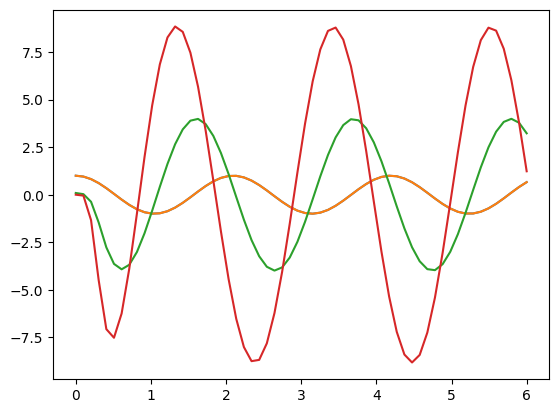

In [311]:
plt.plot(t,z)
plt.plot(t,z_pre)
plt.plot(t,z_dot_pre)
plt.plot(t,z_ddot_pre)

In [304]:
X_pred, P_pred = kfp.predict(N=10)

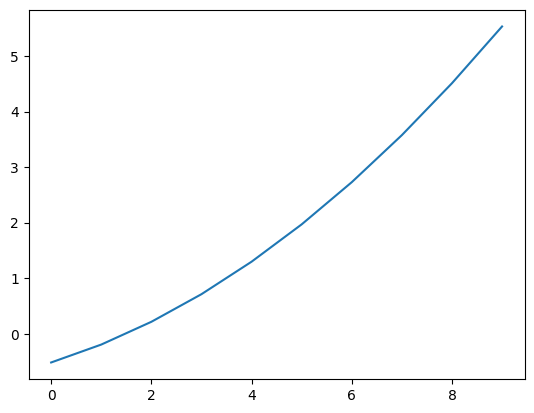

In [308]:
plt.plot(X_pred[0,:])
# plt.plot(P_pred[0,0,:])